#### Main Project Notebook
In this notebook we will perform the steps of the final model training as follows:
* Preprocess the data, split it to train & test sets and create data loaders.
* Overfit a single batch as good practice to make sure the model is working without any errors.
* Train the model on the train set and validate it on the test set.

In [83]:
import pandas as pd
import numpy as np
import torch
import random
from torch import nn
from torchvision import models, transforms, datasets
from torchvision.ops import distance_box_iou_loss , box_iou
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchsummary import summary
from math import floor
from matplotlib.patches import Rectangle
from torch.utils.tensorboard import SummaryWriter
from dataset_class import *
from model_multioutput import *

device = 'cuda' if torch.cuda.is_available() else 'cpu' #checking for gpu availability

train_img_dir = r"C:\Users\matan\Desktop\MLDL_Projects\MNIST_Localization\Data\MNIST_Converted_Training\\"
train_csv_file = r"C:\Users\matan\Desktop\MLDL_Projects\MNIST_Localization\Data\training_data.csv"
test_img_dir = r"C:\Users\matan\Desktop\MLDL_Projects\MNIST_Localization\Data\MNIST_Converted_Testing\\"
test_csv_file = r"C:\Users\matan\Desktop\MLDL_Projects\MNIST_Localization\Data\test_data.csv"

transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(), 
                                transforms.Normalize((0.0102, 0.0102, 0.0102),    # normalize images for training data
                                                    (0.0882, 0.0882, 0.0882))])

In [2]:
# Data preparation and Loaders
train_ds = MNIST(csv_file=train_csv_file , img_dir=train_img_dir, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_ds = MNIST(csv_file=test_csv_file , img_dir=test_img_dir, transform=transform)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

#### Overfitting a single batch

In [19]:
overfit_x , overfit_y = next(iter(train_loader))

def overfit_training_loop(model, optimizer, x, y, epochs):
    for e in range(epochs):
        model.train()
        x = x.to(device)
        true_labels = y['label'].to(device)
        true_bbox = y['bbox'].to(device)

        logits, pred_bbox = model(x)
        classification_loss = F.cross_entropy(logits, true_labels)
        regression_loss = distance_box_iou_loss(pred_bbox, true_bbox, reduction= 'mean')
        loss = classification_loss + regression_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e%50 == 0:
            print(f"Iteration {e} | loss is : {loss.item():.4f}")

In [21]:
# Training our overfitted model
model_to_overfit = LocalizationModel(train_CNN=True).to(device)
optimizer= optim.Adam(model_to_overfit.parameters(), lr=1e-3 , weight_decay=1e-4)

overfit_training_loop(model_to_overfit, optimizer, overfit_x, overfit_y, epochs=300)

Iteration 0 | loss is : 3.8010
Iteration 50 | loss is : 0.7087
Iteration 100 | loss is : 0.1546
Iteration 150 | loss is : 0.1162
Iteration 200 | loss is : 0.0642
Iteration 250 | loss is : 0.0724


#### Training the real model

In [3]:
#Functions for training

def validation_metrics(model, loader):
    num_correct = 0
    total_samples = 0
    total_iou = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            true_labels = y['label'].to(device)
            true_bbox = y['bbox'].to(device)

            logits, pred_bbox = model(x)
            _ , class_pred = logits.max(1)
            num_correct += (class_pred == true_labels).sum()
            num_samples = class_pred.size(0)
            total_samples += num_samples
            iou_lis = [box_iou(pred_bbox[i].unsqueeze(0), true_bbox[i].unsqueeze(0)) for i in range(num_samples)]
            total_iou += sum(iou_lis)

        class_acc = float(num_correct)/total_samples
        iou_avg = float(total_iou)/total_samples

        return (class_acc, iou_avg)

def training_loop(model, optimizer, epochs):
    step_loss = 0
    step_val_metrics = 0

    for e in range(epochs):
        print()
        print(f"Starting epoch {e+1}")
        print()

        for idx, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device)
            true_labels = y['label'].to(device)
            true_bbox = y['bbox'].to(device)

            logits, pred_bbox = model(x)
            classification_loss = F.cross_entropy(logits, true_labels)
            regression_loss = distance_box_iou_loss(pred_bbox, true_bbox, reduction= 'mean')
            loss = classification_loss + regression_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            writer.add_scalar('Total training loss', loss, global_step= step_loss)
            writer.add_scalar('Box IoU training loss', regression_loss, global_step= step_loss)
            writer.add_scalar('Classification training loss', classification_loss, global_step= step_loss)
            step_loss += 1

            if idx%50 == 0:
                class_acc, iou_avg = validation_metrics(model, test_loader)
                writer.add_scalar('Validation class Accuracy', class_acc, global_step= step_val_metrics)
                writer.add_scalar('Validation Average IoU', iou_avg, global_step= step_val_metrics)
                step_val_metrics += 1

                print(f"Epoch {e+1} Batch {idx} | Total training loss: {loss.item():.4f} | Classification training loss: {classification_loss.item():.4f} | Regression training loss: {regression_loss:.4f} | Validation class acc: {100*class_acc:.2f}% | Validation avg IoU: {iou_avg:.4f}")
                print()

In [4]:
# Training our model
# Hyperparams
lr = 1e-3
weight_decay = 1e-4
num_epochs = 5

model_1 = LocalizationModel(train_CNN=True).to(device)
dummy_input = torch.rand(1, 3, 224, 224).to(device)
writer = SummaryWriter(f'TB/model_1')
writer.add_graph(model_1, dummy_input)

optimizer= optim.Adam(model_1.parameters(), lr=lr, weight_decay=weight_decay)
training_loop(model_1, optimizer, epochs=num_epochs)
writer.close()


Starting epoch 1

Epoch 1 Batch 0 | Total training loss: 3.6193 | Classification training loss: 2.3325 | Regression training loss: 1.2868 | Validation class acc: 11.54% | Validation avg IoU: 0.0004

Epoch 1 Batch 50 | Total training loss: 1.0488 | Classification training loss: 0.0852 | Regression training loss: 0.9636 | Validation class acc: 93.60% | Validation avg IoU: 0.0930

Epoch 1 Batch 100 | Total training loss: 1.0314 | Classification training loss: 0.0823 | Regression training loss: 0.9491 | Validation class acc: 64.33% | Validation avg IoU: 0.1021

Epoch 1 Batch 150 | Total training loss: 1.1183 | Classification training loss: 0.1839 | Regression training loss: 0.9344 | Validation class acc: 93.78% | Validation avg IoU: 0.1237

Epoch 1 Batch 200 | Total training loss: 0.8614 | Classification training loss: 0.1239 | Regression training loss: 0.7375 | Validation class acc: 95.91% | Validation avg IoU: 0.3303

Epoch 1 Batch 250 | Total training loss: 0.7181 | Classification trai

#### Model inference, testing and summary
After we reached satisfying results with a final version of the model, we can use it to make predictions on some test samples and compare them to the ground truth.

In [115]:
def sample_test(model, num_samples=1):
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            x , y = test_ds[floor(random.random()*len(test_ds))]
            true_class = y['label']
            true_bbox = y['bbox']
            x1, y1, x2, y2 = [int(c*224) for c in true_bbox]
            true_width = x2 - x1
            true_height = y2 - y1

            x = x.to(device)
            x = x.unsqueeze(0)
            logits , pred_bbox = model(x)
            pred_bbox = pred_bbox.squeeze()
            _ , pred_class = logits.max(1)
            x_1, y_1, x_2, y_2 = [int(c*224) for c in pred_bbox]
            pred_width = x_2 - x_1
            pred_height = y_2 - y_1

            true_rect = Rectangle((x1, y1), true_width, true_height, linewidth=1, edgecolor='g', facecolor='none')
            pred_rect = Rectangle((x_1, y_1), pred_width, pred_height, linewidth=1, edgecolor='r', facecolor='none')
            x = x.squeeze().cpu()

            plt.imshow(x.permute(1,2,0).clamp(0,1))
            plot_axes = plt.gca()
            plot_axes.add_patch(true_rect)
            plot_axes.add_patch(pred_rect)

            legend_handles = [patches.Patch(color='r', label='Model bbox'),
                              patches.Patch(color='g', label='True bbox')]
            
            plot_axes.legend(handles=legend_handles, loc='upper right')
            plt.show()
            print(f"Model's class prediction is: {pred_class.item()}")

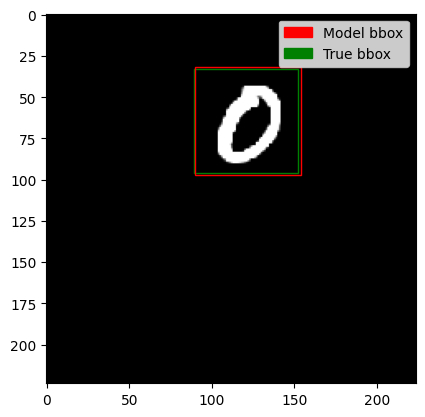

Model's class prediction is: 0


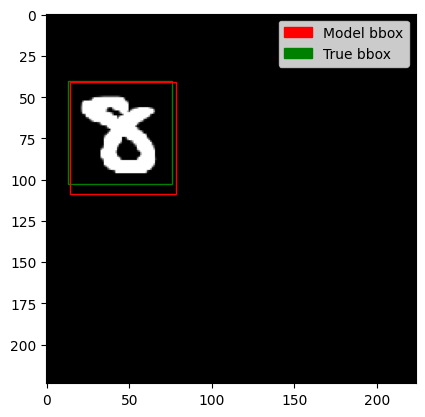

Model's class prediction is: 8


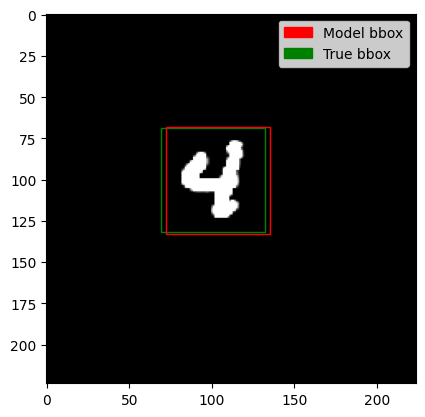

Model's class prediction is: 4


In [133]:
sample_test(model_1, num_samples=3)